In [1]:
import sys

!{sys.executable} -m pip install setuptools
!{sys.executable} -m pip install python-dotenv
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install mlflow
!{sys.executable} -m pip install dagshub
!{sys.executable} -m pip install keras-tuner
!{sys.executable} -m pip install scikeras


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import mlflow
import mlflow.tensorflow
import dagshub
from scipy.stats import randint

In [4]:
# set up dagshub for mlflow tracking
dagshub.init(repo_owner='JonaKoenemann', repo_name='machine_failure_classification', mlflow=True)

Initialized MLflow to track repo "JonaKoenemann/machine_failure_classification"

Repository JonaKoenemann/machine_failure_classification initialized!

# Data preparation

In [5]:
# Load data
data_path = "../../../data/predictive_maintenance.csv"
df = pd.read_csv(data_path)

In [6]:
# Define features
categorical_features = ['Type']
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_features.remove('UDI')
numerical_features.remove('Target')

# Preprocessing
poly = PolynomialFeatures(degree=2, include_bias=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler())
            # ('poly', poly)
        ]), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

In [7]:
# Split data
X = df[numerical_features + categorical_features]
y = df["Failure Type"]

# Encode target variable as categorical
y_encoded = pd.get_dummies(y).values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Verify the shape of the transformed data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print("Transformed X_train shape:", X_train_transformed.shape)
print("Transformed X_test shape:", X_test_transformed.shape)

Transformed X_train shape: (8000, 8)
Transformed X_test shape: (2000, 8)


# Model creation

In [8]:
mlflow.set_experiment("neural_net_rs_feature")

<Experiment: artifact_location='mlflow-artifacts:/5d070a7a848a4292978b8f295b25d38f', creation_time=1718893734590, experiment_id='6', last_update_time=1718893734590, lifecycle_stage='active', name='neural_net_rs_feature', tags={}>

In [9]:
# Define the model for multi-class classification
def create_model(input_dim, optimizer='adam'):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(6, activation='softmax'))  # 6 output units for 6 classes
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
# Wrap the model using KerasClassifier
model = KerasClassifier(model=create_model, input_dim=X_train_transformed.shape[1], verbose=0)

# Train and test

In [11]:
# Create a pipeline that includes preprocessing and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

In [12]:
# Define RandomizedSearchCV
param_dist = {
    'classifier__batch_size': [10, 20, 40, 60, 80, 100],
    'classifier__epochs': [10, 50, 100],
    'classifier__optimizer': ['adam', 'rmsprop']
}

In [13]:
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, cv=3, n_iter=10, scoring='f1_weighted', verbose=1)

In [14]:
with mlflow.start_run() as run:
    # Fit random search
    random_search_result = random_search.fit(X_train, y_train)
    
    # Log the best parameters and metrics
    mlflow.log_params(random_search_result.best_params_)
    mlflow.log_metric("best_score", random_search_result.best_score_)
    
    # Train the best model on the test data
    best_model = random_search_result.best_estimator_
    y_pred = best_model.predict(X_test)
    test_accuracy = best_model.score(X_test, y_test)
    mlflow.log_metric("test_accuracy", test_accuracy)
    
    # Calculate and log the F1 score
    test_f1_score = f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')
    mlflow.log_metric("test_f1_score", test_f1_score)
    
    print(f"Best Parameters: {random_search_result.best_params_}")
    print(f"Best CV F1 Score: {random_search_result.best_score_}")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test F1 Score: {test_f1_score}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/noah/anaconda3/envs/dski_ml/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/noah/anaconda3/envs/dski_ml/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/noah/anaconda3/envs/dski_ml/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super

Best Parameters: {'classifier__optimizer': 'rmsprop', 'classifier__epochs': 100, 'classifier__batch_size': 20}
Best CV F1 Score: 0.9816514245022289
Test Accuracy: 0.982
Test F1 Score: 0.9786012638074533


# Evaluation

In [15]:
error_names = [
 'Heat Failure',
 'No Failure',
 'Overstrain Failure',
 'Power Failure',
 'Random Failure',
 'Tool wear Failure'] # get names of errors in correct order for confusion matrix

## Classification report

In [16]:
# Use the best model from random_search_result for predictions
best_model = random_search_result.best_estimator_

# Make predictions on the test data
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the classification report
print(classification_report(y_test.argmax(axis=1), y_pred_classes))


              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.99      0.99      0.99      1935
           2       0.85      0.85      0.85        13
           3       0.74      0.85      0.79        20
           4       0.00      0.00      0.00         6
           5       1.00      0.09      0.17        11

    accuracy                           0.98      2000
   macro avg       0.71      0.57      0.58      2000
weighted avg       0.98      0.98      0.98      2000



/Users/noah/anaconda3/envs/dski_ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/noah/anaconda3/envs/dski_ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/noah/anaconda3/envs/dski_ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

## Normalized confusion matrix

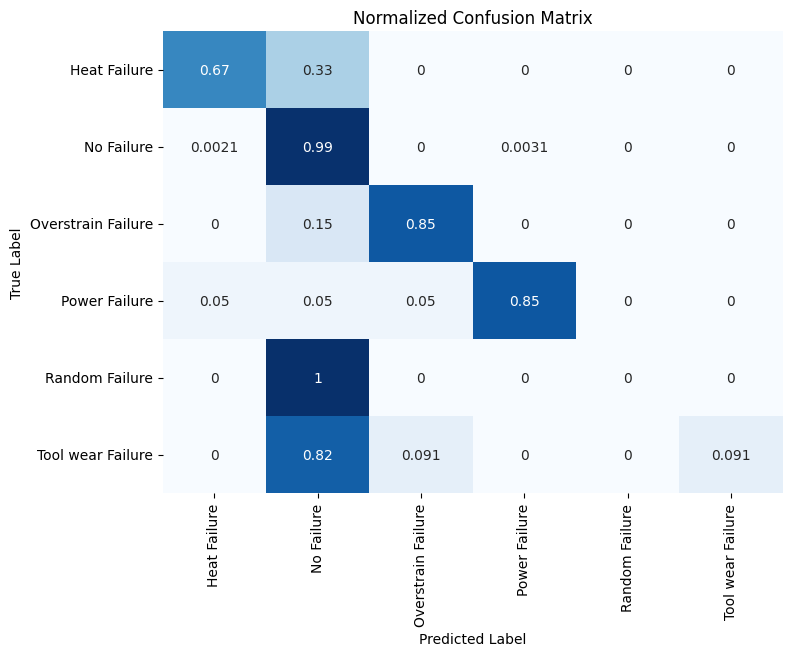

In [17]:
# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the normalized confusion matrix
conf_matrix_normalized = confusion_matrix(y_true_classes, y_pred_classes, normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, cmap="Blues", cbar=False, xticklabels=error_names, yticklabels=error_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()

## Train and validation loss

Konnte das bisher noch nicht fixen. Scheint so als ob es `loss` oder `val_loss` nicht gibt.


`The keys 'loss' and 'val_loss' are not available in the history object.`

In [18]:
# Access the Keras model from the pipeline
keras_model = best_model.named_steps['classifier'].model_

# Retrieve the history from the Keras model
history = keras_model.history.history

# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


KeyError: 'loss'

<Figure size 800x600 with 0 Axes>

In [ ]:
# Access the Keras model from the pipeline
keras_model = best_model.named_steps['classifier'].model_

# Print the keys in the history object to understand its structure
history = keras_model.history.history
print("Available keys in history:", history.keys())


Available keys in history: dict_keys([])


In [ ]:
# Plot the training and validation loss if available in history
if 'loss' in history and 'val_loss' in history:
    plt.figure(figsize=(8, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
else:
    print("The keys 'loss' and 'val_loss' are not available in the history object.")


The keys 'loss' and 'val_loss' are not available in the history object.
